# AI-Based Anomaly Detection for Linux System Logs (SIEM Project)

##  Objective
This notebook is part of a modular SIEM system where machine learning models are used to detect anomalies in system activity logs. We focus on Linux logs and train separate models for different log types to identify malicious or suspicious behavior in real-time.

Our goal is to:
- Train unsupervised anomaly detection models (e.g., Isolation Forest) on Linux logs.
- Use each model to flag abnormal system behavior.
- Lay the foundation for integrating the models into a larger AI-powered SIEM backend.


## Our multi-model approach

Each Linux log dataset (e.g., process, memory, disk) contains very different types of data and features. Training separate models per dataset allows us to:

- Tailor preprocessing steps to each dataset.
- Improve model interpretability and accuracy.
- Easily scale and debug each component of the system.

This modular design also aligns with how logs are handled in real-world SIEMs — each log type is processed independently, then correlated later during analysis.


In [1]:
import pandas as pd

# Load datasets
df_process = pd.read_csv("/kaggle/input/siem-datasets/Linux_process_1(in).csv")
df_memory = pd.read_csv("/kaggle/input/siem-datasets/linux_disk_1(in).csv")
df_disk = pd.read_csv("/kaggle/input/siem-datasets/linux_disk_1(in).csv")
df_network


/tmp/ipykernel_31/3021020646.py:5: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_memory = pd.read_csv("/kaggle/input/siem-datasets/linux_disk_1(in).csv")
/tmp/ipykernel_31/3021020646.py:6: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_disk = pd.read_csv("/kaggle/input/siem-datasets/linux_disk_1(in).csv")


NameError: name 'df_network' is not defined

## Dataset 1: Linux Process Logs

We begin by exploring the `Linux_process_dataset.csv`, which contains information about processes running on the system. This includes CPU usage, memory footprint, user, and execution state.

We'll:
- Explore feature distributions
- Check for missing values
- Prepare the dataset for training an anomaly detection model


In [14]:
print("Shape of the dataset:", df_process.shape)
print("\nData Types:\n", df_process.dtypes)
print("\nSummary Statistics:\n", df_process.describe())
print("\nMissing Values:\n", df_process.isnull().sum())
print("\nUnique values in object columns:\n")
for col in df_process.select_dtypes(include='object'):
    print(f"{col}: {df_process[col].nunique()}")

Shape of the dataset: (1000000, 17)

Data Types:
 ts          int64
PID         int64
TRUN        int64
TSLPI       int64
TSLPU       int64
POLI       object
NICE        int64
PRI         int64
RTPR        int64
CPUNR       int64
Status     object
EXC         int64
State      object
CPU       float64
CMD        object
label       int64
type       object
dtype: object

Summary Statistics:
                  ts             PID            TRUN           TSLPI  \
count  1.000000e+06  1000000.000000  1000000.000000  1000000.000000   
mean   1.556061e+09     3394.386166        0.083634        2.906525   
std    8.139634e+05     1934.219302        0.280705        4.423690   
min    1.554219e+09     1007.000000        0.000000        0.000000   
25%    1.555469e+09     2533.000000        0.000000        1.000000   
50%    1.556320e+09     3155.000000        0.000000        1.000000   
75%    1.556620e+09     4147.000000        0.000000        3.000000   
max    1.557423e+09    53080.000000     

Class distribution (proportion):
 label
0    0.879245
1    0.120755
Name: proportion, dtype: float64


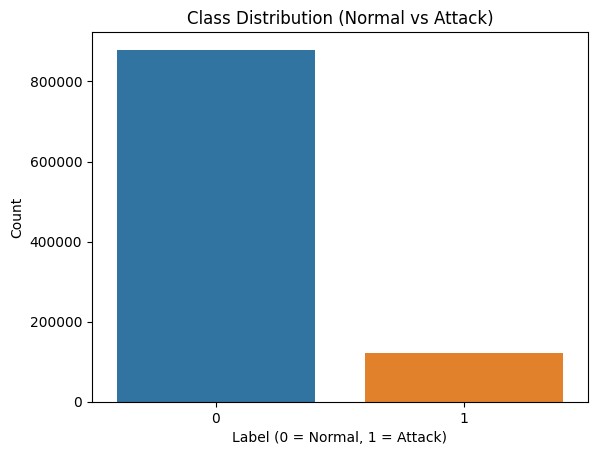

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


label_counts = df_process['label'].value_counts(normalize=True)
print("Class distribution (proportion):\n", label_counts)


sns.countplot(data=df_process, x='label')
plt.title('Class Distribution (Normal vs Attack)')
plt.xlabel('Label (0 = Normal, 1 = Attack)')
plt.ylabel('Count')
plt.show()


## We can see clearly that there is a huge imbalance between the two classes , we will deal with it later 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

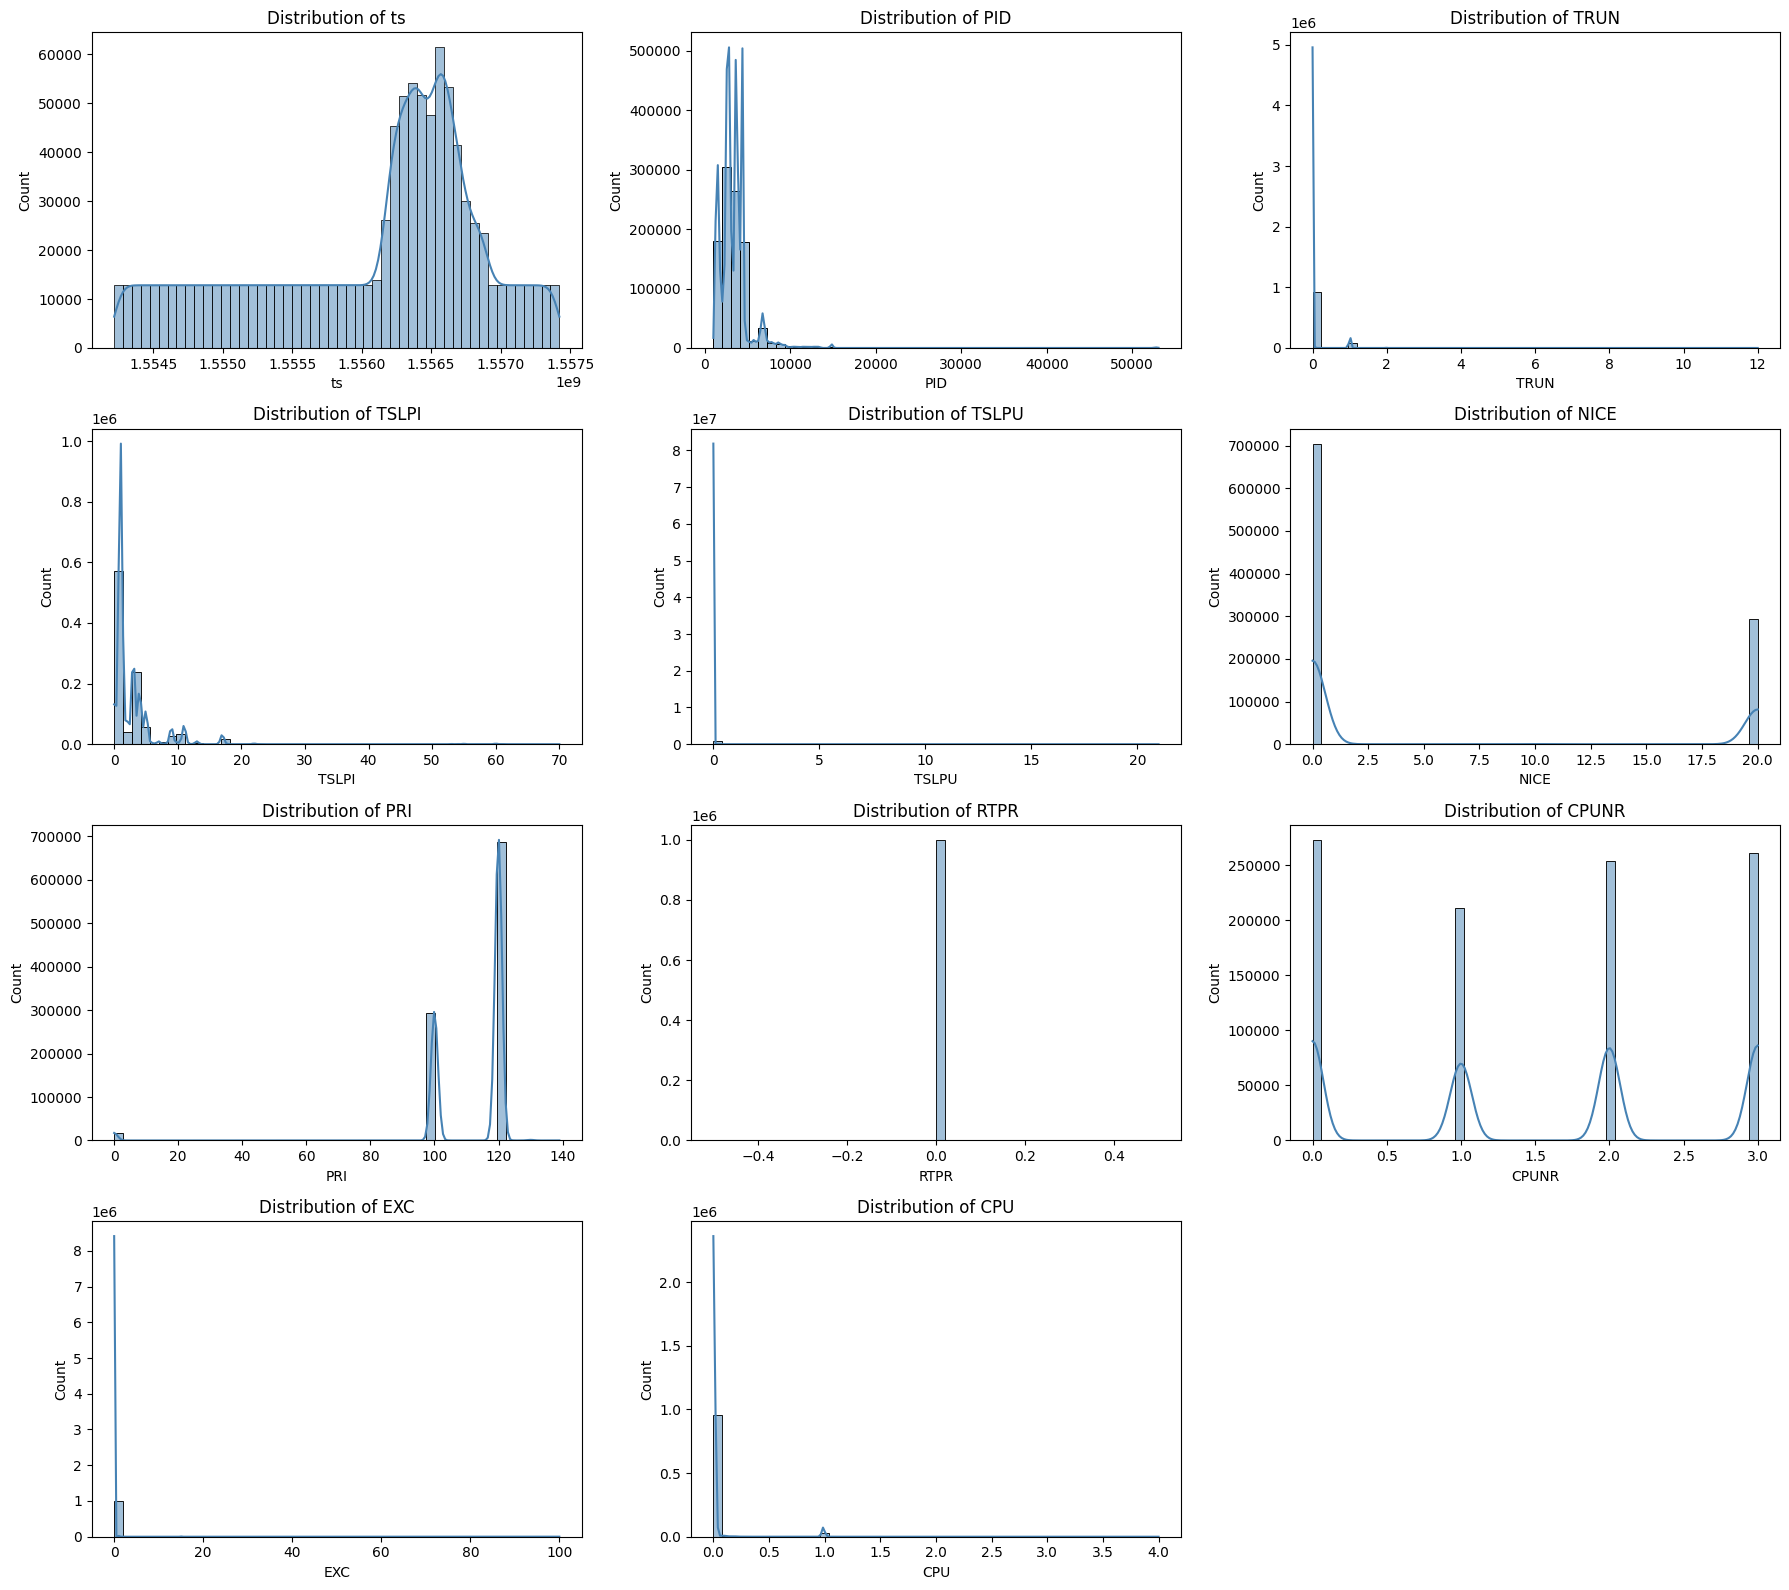

In [16]:
numeric_cols = df_process.select_dtypes(include=['int64', 'float64']).drop(columns=['label'])


n_cols = 3
n_rows = (len(numeric_cols.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(18, 4 * n_rows))


for idx, col in enumerate(numeric_cols.columns, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(df_process[col], kde=True, bins=50, color='steelblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

# Observations : 

## we know that  PID is essentially a random or sequential number with no semantic meaning. It doesn't correlate with behavior, usage, CPU load, or anomalies. so we will drop it

## we can see clearly that RTPR is a dead feature , so it will be dropped as well

## for ts , we'll convert it into meaningful temporal components

## for TRUN, TSLPI, TSLPU, EXC, CPU : We should apply a log1p transformation to compress outliers and stabilize variance.



In [17]:
import numpy as np

df_process = df_process.drop(columns=['PID', 'RTPR'])
df_process['ts'] = pd.to_datetime(df_process['ts'], unit='s')  # Convert UNIX timestamp to datetime
df_process['hour'] = df_process['ts'].dt.hour
df_process['day_of_week'] = df_process['ts'].dt.dayofweek
df_process['is_weekend'] = df_process['day_of_week'].isin([5, 6]).astype(int)
df_process = df_process.drop(columns=['ts'])



In [18]:

import numpy as np
from sklearn.preprocessing import StandardScaler

# Log transformation for skewed columns
log_cols = ['TRUN', 'TSLPI', 'TSLPU', 'EXC', 'CPU']
df_process[log_cols] = df_process[log_cols].apply(np.log1p)

# Scaling selected numerical columns
scale_cols = ['NICE', 'PRI', 'CPUNR', 'hour', 'day_of_week']
scaler = StandardScaler()
df_process[scale_cols] = scaler.fit_transform(df_process[scale_cols])

# Confirmation output
print("Applied transformations.")
print("New shape:", df_process.shape)
print("Columns after processing:", df_process.columns.tolist())


Applied transformations.
New shape: (1000000, 17)
Columns after processing: ['TRUN', 'TSLPI', 'TSLPU', 'POLI', 'NICE', 'PRI', 'CPUNR', 'Status', 'EXC', 'State', 'CPU', 'CMD', 'label', 'type', 'hour', 'day_of_week', 'is_weekend']


### Categorical Feature Handling

- **POLI**, **State**, and **Status** have **low cardinality**, so they will be encoded using **one-hot encoding**.
- **CMD** has **high cardinality (328 unique values)**. Including it directly may introduce **noise**, increase **dimensionality**, and cause **overfitting**. Therefore, it will be **dropped** from the dataset.


In [19]:
# One-hot encode low-cardinality categorical features
categorical_cols = ['POLI', 'Status', 'State']
df_process = pd.get_dummies(df_process, columns=categorical_cols, drop_first=True)

# Drop high-cardinality CMD
df_process = df_process.drop(columns=['CMD'])

print("Applied one-hot encoding to low-cardinality categorical features.")
print("Dropped 'CMD' due to high cardinality.")
print("New shape:", df_process.shape)


Applied one-hot encoding to low-cardinality categorical features.
Dropped 'CMD' due to high cardinality.
New shape: (1000000, 26)


In [20]:
df_process = df_process.drop(columns=['type'])
print("'type' column dropped to avoid label leakage.")


'type' column dropped to avoid label leakage.


## Class Imbalance in the `label` Column

We observed earlier that the `label` column is highly imbalanced:

- **Normal (label = 0)**: ~88%  
- **Anomalous (label = 1)**: ~12%

Such imbalance can cause issues like:
- The model favoring the majority class, missing critical anomalies.
- Misleadingly high accuracy while performing poorly on actual threat detection.

---

## Strategy for Handling Imbalance

We applied **RandomOverSampler**, a technique that balances the dataset by **replicating samples from the minority class**:

- No information is discarded (unlike undersampling).
- Unlike SMOTE, it avoids dtype and data structure issues, making it robust for our mixed-type dataset.
- It's fast and effective for training traditional classifiers.

 Oversampling was applied **only on the training set** to prevent data leakage.

---

## Evaluation Metrics

Given the class imbalance, we’ll rely on more informative metrics than accuracy:
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC**

In [12]:
!pip uninstall scikit-learn imbalanced-learn -y
!pip cache purge
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 84.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [22]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


X = df_process.drop(columns=['label'])
y = df_process['label']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Training set after RandomOverSampler:")
print("Label distribution:\n", y_train_resampled.value_counts(normalize=True))
print("Training shape:", X_train_resampled.shape)
print("Test shape:", X_test.shape)


Training set after RandomOverSampler:
Label distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64
Training shape: (1406792, 24)
Test shape: (200000, 24)



Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.81      0.88    175849
           1       0.37      0.82      0.51     24151

    accuracy                           0.81    200000
   macro avg       0.67      0.82      0.70    200000
weighted avg       0.90      0.81      0.84    200000

ROC-AUC: 0.863113465928067


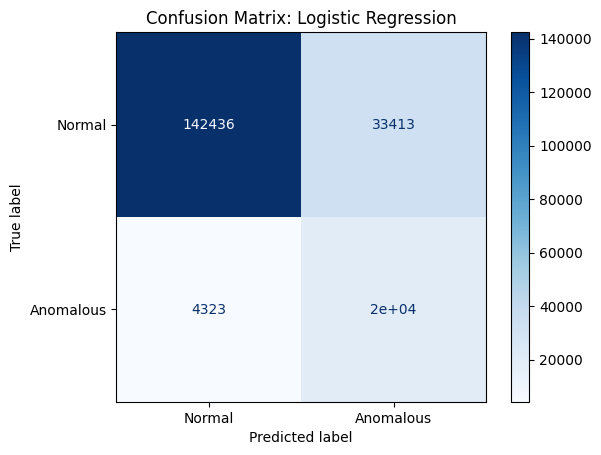


Random Forest
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    175849
           1       0.62      0.94      0.75     24151

    accuracy                           0.92    200000
   macro avg       0.81      0.93      0.85    200000
weighted avg       0.95      0.92      0.93    200000

ROC-AUC: 0.9829605856115897


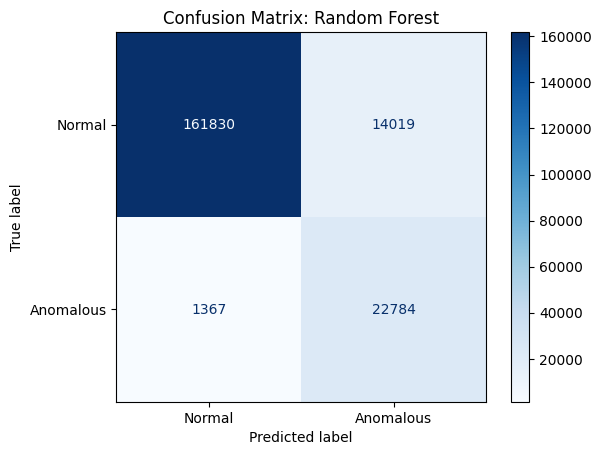


XGBoost
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    175849
           1       0.61      0.95      0.75     24151

    accuracy                           0.92    200000
   macro avg       0.80      0.93      0.85    200000
weighted avg       0.95      0.92      0.93    200000

ROC-AUC: 0.9858980605294523


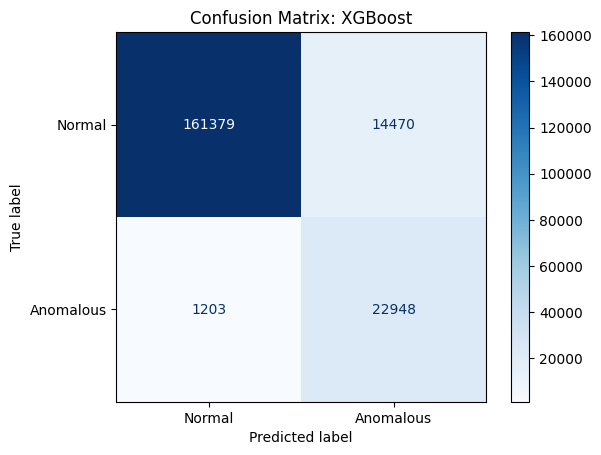

In [23]:


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


for name, model in models.items():
    print(f"\n\033[1m{name}\033[0m")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

    
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Normal", "Anomalous"], cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix: {name}")
    plt.show()


### Hyperparameter Tuning with RandomizedSearchCV
After the training, it's clear that XGBoost has the highest ROC-AUC (0.9859) and strong class balance in F1-score, so we will continue with it .
Now are applying randomized search to tune the hyperparameters of the XGBoost model.  
This method samples a fixed number of parameter combinations from a specified grid and performs cross-validation to find the best one.  
It is faster than exhaustive grid search and provides a good trade-off between performance and speed.

Configuration:
- 20 parameter combinations
- 3-fold stratified cross-validation
- Scoring metric: ROC-AUC
- Parallel jobs: All available cores


In [24]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_resampled, y_train_resampled)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.6; total time= 1.0min
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=  34.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=  34.0s


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  31.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=  19.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1.5, subsample=1.0; total time=  57.5s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=  25.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=  35.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time= 2.1min
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importa...
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=2)

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.6; total time= 1.0min
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=7, n_estimators=400, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time= 1.6min
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=  33.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=  21.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=400, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=  59.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_est

In [25]:
from xgboost import XGBClassifier


best_params = random_search.best_params_
print("Best Parameters:", best_params)


final_xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    **best_params
)

final_xgb.fit(X_train_resampled, y_train_resampled)


Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [26]:
import joblib

joblib.dump(final_xgb, "xgb_process_model.joblib")
print("Model saved as xgb_process_model.joblib")


Model saved as xgb_process_model.joblib


## Dataset 2: Linux Memory Logs

We'll:
- Explore feature distributions
- Check for missing values
- Prepare the dataset for training an anomaly detection model


In [2]:
print("Shape of the dataset:", df_memory.shape)
print("\nData Types:\n", df_memory.dtypes)
print("\nSummary Statistics:\n", df_memory.describe())
print("\nMissing Values:\n", df_memory.isnull().sum())
print("\nUnique values in object columns:\n")
for col in df_memory.select_dtypes(include='object'):
    print(f"{col}: {df_memory[col].nunique()}")

Shape of the dataset: (1000000, 9)

Data Types:
 ts         int64
PID        int64
RDDSK     object
WRDSK     object
WCANCL    object
DSK       object
CMD       object
label      int64
type      object
dtype: object

Summary Statistics:
                  ts             PID           label
count  1.000000e+06  1000000.000000  1000000.000000
mean   1.556585e+09     6920.122894        0.194078
std    6.084939e+05     6526.648898        0.395489
min    1.554217e+09     1007.000000        0.000000
25%    1.556359e+09     2366.000000        0.000000
50%    1.556618e+09     3112.000000        0.000000
75%    1.556957e+09    14215.000000        0.000000
max    1.557593e+09    23541.000000        1.000000

Missing Values:
 ts        0
PID       0
RDDSK     0
WRDSK     0
WCANCL    0
DSK       0
CMD       0
label     0
type      0
dtype: int64

Unique values in object columns:

RDDSK: 878
WRDSK: 1098
WCANCL: 80
DSK: 291
CMD: 642
type: 7


Class distribution (proportion):
 label
0    0.805922
1    0.194078
Name: proportion, dtype: float64


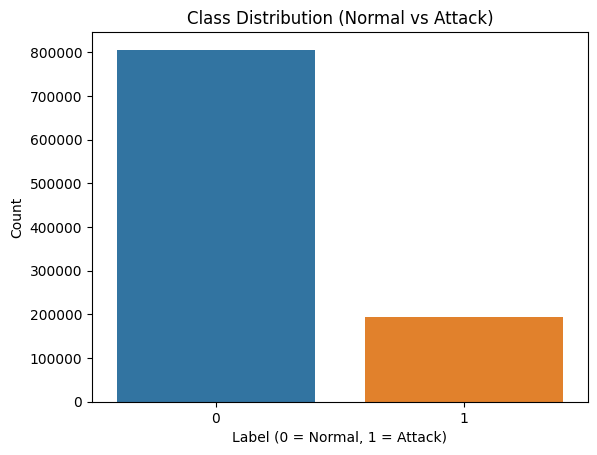

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


label_counts = df_memory['label'].value_counts(normalize=True)
print("Class distribution (proportion):\n", label_counts)


sns.countplot(data=df_memory, x='label')
plt.title('Class Distribution (Normal vs Attack)')
plt.xlabel('Label (0 = Normal, 1 = Attack)')
plt.ylabel('Count')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


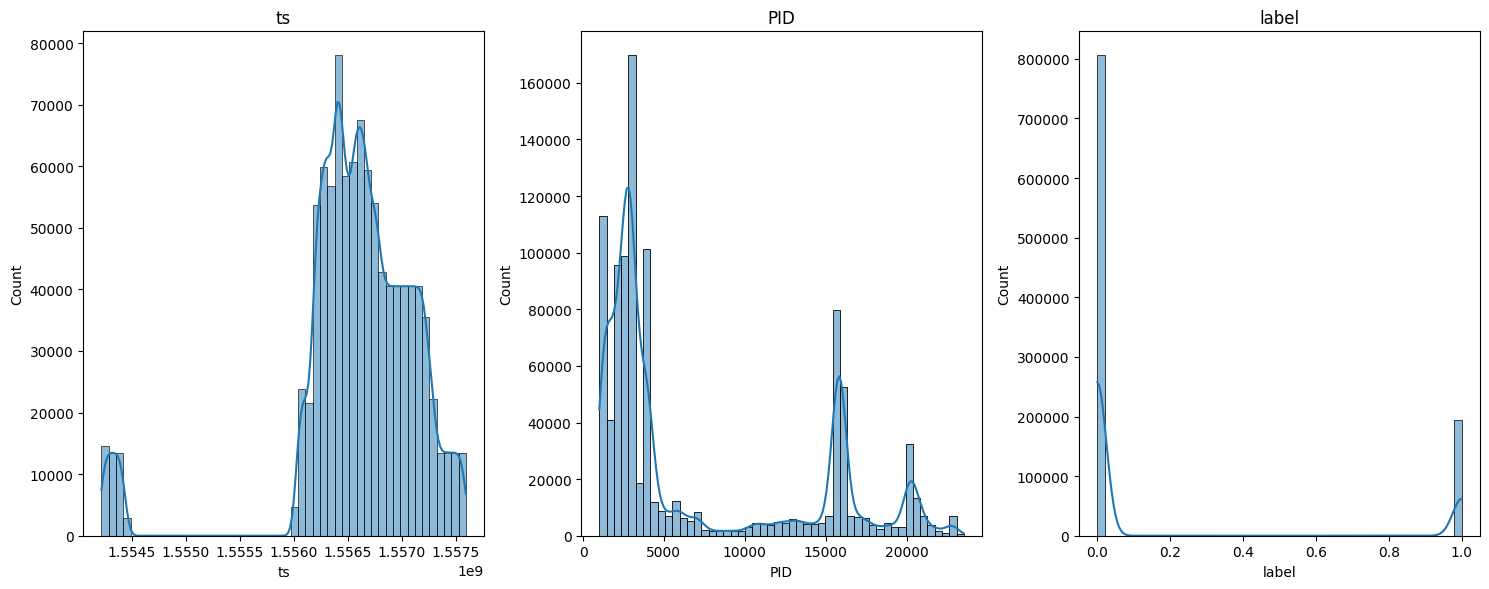

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numeric columns
numeric_cols = df_memory.select_dtypes(include=['int64', 'float64']).columns

# Plot distributions
plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.histplot(df_memory[col], bins=50, kde=True)
    plt.title(col)
    plt.tight_layout()


## Initial Preprocessing: PID Removal and Timestamp Transformation

The current dataset contains numeric and object-type features. Before we explore the object columns, we begin with the following preprocessing steps:

1. **Drop `PID`** (as explained before)

2. **Transform `ts` (timestamp)**:  
   The `ts` column is in Unix epoch format. To enhance the temporal understanding of the model, we extract relevant time-based features:
   - `hour`: Hour of the day
   - `day_of_week`: Day of the week (0 = Monday, 6 = Sunday)
   - `is_weekend`: Boolean indicating if the timestamp falls on a weekend

These transformations allow the model to detect potential temporal patterns related to anomalies (e.g., unusual memory activity during weekends or off-hours).

Once these are completed, we will begin a detailed inspection of object-type columns, which include a mix of potentially categorical and high-cardinality features that require special handling.


In [5]:
import pandas as pd

# Drop PID
df_memory.drop(columns=["PID"], inplace=True)

# Convert ts to datetime
df_memory["ts"] = pd.to_datetime(df_memory["ts"], unit="s")

# Extract time-based features
df_memory["hour"] = df_memory["ts"].dt.hour
df_memory["day_of_week"] = df_memory["ts"].dt.dayofweek
df_memory["is_weekend"] = df_memory["day_of_week"] >= 5

# Drop original ts column
df_memory.drop(columns=["ts"], inplace=True)

# Display updated columns
df_memory.head()


,RDDSK,WRDSK,WCANCL,DSK,CMD,label,type,hour,day_of_week,is_weekend
0,148.2,37340,12328,0.22,firefox,0,normal,15,1,False
1,32824.0,688,4,0.04,init,0,normal,15,1,False
2,23468.0,7416,6152,0.04,nautilus,0,normal,15,1,False
3,3612.0,14320,0,0.02,tracer-store,0,normal,15,1,False
4,5184.0,11152,0,0.02,zeitgeist-fts,0,normal,15,1,False


In [6]:
# Select object-type columns
object_cols = df_memory.select_dtypes(include='object').columns

# Explore each object column
for col in object_cols:
    print(f"\n--- {col} ---")
    print(f"Unique values: {df_memory[col].nunique()}")
    print(f"Top 5 most frequent values:\n{df_memory[col].value_counts().head()}")
    print(f"\nSample of 5 least frequent values:\n{df_memory[col].value_counts().tail()}")
    print(f"\nTop value proportion: {df_memory[col].value_counts(normalize=True).iloc[0]:.4f}")



--- RDDSK ---
Unique values: 878
Top 5 most frequent values:
RDDSK
0.0    867409
0       72779
0K      56688
4.0       370
4K        155
Name: count, dtype: int64

Sample of 5 least frequent values:
RDDSK
336K      1
4480K     1
4496K     1
5272K     1
2508.0    1
Name: count, dtype: int64

Top value proportion: 0.8674

--- WRDSK ---
Unique values: 1098
Top 5 most frequent values:
WRDSK
0     645647
0     125998
4      85368
0K     45617
8      25067
Name: count, dtype: int64

Sample of 5 least frequent values:
WRDSK
2784       1
3404       1
3780       1
3652       1
20804.0    1
Name: count, dtype: int64

Top value proportion: 0.6456

--- WCANCL ---
Unique values: 80
Top 5 most frequent values:
WCANCL
0      863530
0      129800
4        5261
4        1205
8.0        37
Name: count, dtype: int64

Sample of 5 least frequent values:
WCANCL
7068    1
3772    1
2.5     1
6940    1
2472    1
Name: count, dtype: int64

Top value proportion: 0.8635

--- DSK ---
Unique values: 291
Top 5 mos

In [7]:
import pandas as pd
import numpy as np


object_cols_to_clean = ['RDDSK', 'WRDSK', 'WCANCL', 'DSK']

def clean_disk_column(series):
    def convert_value(val):
        try:
            
            val = str(val).strip()

            if val.endswith('K'):
                
                return float(val[:-1]) * 1024
            elif val.endswith('%'):
                
                return float(val[:-1]) / 100
            else:
                
                return float(val)
        except:
            return np.nan  

    return series.apply(convert_value)

# Apply cleaning function to each target column
for col in object_cols_to_clean:
    df_memory[col] = clean_disk_column(df_memory[col])

# Check result
print(df_memory[object_cols_to_clean].dtypes)
print(df_memory[object_cols_to_clean].head())


RDDSK     float64
WRDSK     float64
WCANCL    float64
DSK       float64
dtype: object
     RDDSK    WRDSK   WCANCL   DSK
0    148.2  37340.0  12328.0  0.22
1  32824.0    688.0      4.0  0.04
2  23468.0   7416.0   6152.0  0.04
3   3612.0  14320.0      0.0  0.02
4   5184.0  11152.0      0.0  0.02


In [8]:
# Check for missing values
print("Missing values per column:")
print(df_memory[['RDDSK', 'WRDSK', 'WCANCL', 'DSK']].isna().sum())

# Check for rows with any missing values in transformed columns
print("\nSample rows with missing values (if any):")
print(df_memory[df_memory[['RDDSK', 'WRDSK', 'WCANCL', 'DSK']].isna().any(axis=1)].head())


Missing values per column:
RDDSK        6
WRDSK     2109
WCANCL       0
DSK          0
dtype: int64

Sample rows with missing values (if any):
        RDDSK  WRDSK  WCANCL  DSK             CMD  label    type  hour  \
362801    1.0    NaN     2.5  1.0  apt.systemd.da      0  normal    19   
492127    0.0    NaN     0.0  0.0  <gnome-termin>      0  normal    18   
492133    0.0    NaN     0.0  0.0          <bash>      1     dos    18   
492173    0.0    NaN     0.0  0.0         <clear>      1     dos    18   
492182    0.0    NaN     0.0  0.0  <systemd-udev>      0  normal    18   

        day_of_week  is_weekend  
362801            1       False  
492127            2       False  
492133            2       False  
492173            2       False  
492182            2       False  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
# Drop rows with missing values in RDDSK or WRDSK
df_memory.dropna(subset=['RDDSK', 'WRDSK'], inplace=True)


### Cleaning of Disk-Related Features: `RDDSK`, `WRDSK`, `WCANCL`, and `DSK`

#### Original Format
The columns `RDDSK`, `WRDSK`, `WCANCL`, and `DSK` were originally of type `object`, containing inconsistent formats such as:
- Text-based zeros: `"0"`, `"0.0"`
- Values with units: `"4K"`, `"336K"`
- Float-like strings: `"4.0"`, `"2508.0"`

This inconsistency prevented proper numerical analysis and model integration.

#### Importance of These Features
These columns represent read/write disk activity and cancellations, which are vital indicators of abnormal or high-load behavior in a system. Proper interpretation is necessary for accurate anomaly detection.

#### Cleaning Process
1. **Unit Normalization**:
   - Removed `"K"` suffix and converted values to bytes by multiplying by 1024.
   - Converted all values to float.

2. **Handling Invalid Entries**:
   - Used a safe conversion method to turn all parsable values into `float64`.
   - Unparsable entries were set to `NaN`.

3. **Dealing with Missing Values**:
   - Dropped rows with `NaN` in `RDDSK` or `WRDSK` (only ~0.2% of the data).

#### Final Result
The four columns are now consistently numeric and suitable for modeling:
- Data type: `float64`
- No missing values
- Semantically accurate representation of disk usage activity


### Encoding the 'CMD' Column with Smoothed Target Encoding

To convert the categorical `CMD` column into a numerical format suitable for model training and inference, we applied **Smoothed Target Encoding**.

#### Objective
The goal is to retain the predictive signal from the `CMD` feature while ensuring that the encoded values are stable and generalizable to unseen data.

#### Method: Smoothed Target Encoding
Instead of using one-hot encoding or arbitrary integer encoding, we compute the **mean of the target variable** (`label`) for each unique category in the `CMD` column. This allows the encoding to reflect the strength of association between each command and the probability of an anomaly.

However, categories that appear infrequently may result in unreliable means. To mitigate this, we use **smoothing** to blend each category's mean with the global mean of the target variable, based on the number of occurrences of that category.

#### Why This Approach?
- It generates a single numerical feature that captures the relationship between each command and anomalies.
- It avoids overfitting to rare categories by smoothing.
- It can be **safely reused in production** by storing the mapping.
- Unseen categories during inference default to the global mean, ensuring stability.

This technique helps the model make better use of categorical information while remaining robust and scalable in a real-time anomaly detection system.


In [10]:
# Global mean for fallback
global_cmd_mean = df_memory['label'].mean()

# Encoding mapping using smoothing
def get_cmd_target_encoding_map(df, cat_col='CMD', target_col='label', smoothing=10):
    target_mean = df[target_col].mean()
    agg = df.groupby(cat_col)[target_col].agg(['mean', 'count'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts * means + smoothing * target_mean) / (counts + smoothing)
    return smooth.to_dict(), target_mean

# Generate the encoding map
cmd_encoding_map, cmd_global_mean = get_cmd_target_encoding_map(df_memory)

# Apply encoding
df_memory['CMD_encoded'] = df_memory['CMD'].map(cmd_encoding_map).fillna(cmd_global_mean)

# Drop the original CMD column
df_memory.drop(columns=['CMD'], inplace=True)

# Save the map and global mean for use in live inference
# (you could pickle it or export to a JSON depending on deployment plan)


In [13]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Feature-target split
X = df_memory.drop(columns=['label', 'type'])  # 'type' already dropped earlier
y = df_memory['label']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42, n_jobs=-1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Confirm class distribution after resampling
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_train_resampled))


/usr/local/lib/python3.11/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class distribution after SMOTE: Counter({0: 644092, 1: 644092})


In [14]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Common parameters
common_params = {
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

# Initialize models
models = {
    "XGBoost": XGBClassifier(**common_params),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Train and evaluate
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    print(classification_report(y_val, y_pred, digits=4))
    print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")



=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9856    0.7994    0.8828    161024
           1     0.5317    0.9514    0.6821     38554

    accuracy                         0.8287    199578
   macro avg     0.7587    0.8754    0.7825    199578
weighted avg     0.8979    0.8287    0.8440    199578

ROC-AUC Score: 0.9368
F1 Score: 0.6821

=== LightGBM ===
[LightGBM] [Info] Number of positive: 644092, number of negative: 644092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 1288184, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0     0.9862    0.7917    0

In [15]:
# Calculate scale_pos_weight
normal_count = (y_train == 0).sum()
anomaly_count = (y_train == 1).sum()
scale_pos_weight = normal_count / anomaly_count

print(f"scale_pos_weight: {scale_pos_weight:.4f}")


scale_pos_weight: 4.1766


In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define parameter grid
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric="logloss")

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring="f1",
    n_iter=25,
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1]))


Fitting 3 folds for each of 25 candidates, totalling 75 fits
              precision    recall  f1-score   support

           0       0.99      0.80      0.88    161024
           1       0.53      0.95      0.68     38554

    accuracy                           0.83    199578
   macro avg       0.76      0.88      0.78    199578
weighted avg       0.90      0.83      0.85    199578

ROC-AUC Score: 0.9380970007700058


In [18]:
import joblib

# Save the trained model
joblib.dump(best_model, "xgb_memory_model.pkl")

['xgb_memory_model.pkl']

In [19]:
print("Shape of the dataset:", df_disk.shape)
print("\nData Types:\n", df_disk.dtypes)
print("\nSummary Statistics:\n", df_disk.describe())
print("\nMissing Values:\n", df_disk.isnull().sum())
print("\nUnique values in object columns:\n")
for col in df_disk.select_dtypes(include='object'):
    print(f"{col}: {df_disk[col].nunique()}")

Shape of the dataset: (1000000, 9)

Data Types:
 ts         int64
PID        int64
RDDSK     object
WRDSK     object
WCANCL    object
DSK       object
CMD       object
label      int64
type      object
dtype: object

Summary Statistics:
                  ts             PID           label
count  1.000000e+06  1000000.000000  1000000.000000
mean   1.556585e+09     6920.122894        0.194078
std    6.084939e+05     6526.648898        0.395489
min    1.554217e+09     1007.000000        0.000000
25%    1.556359e+09     2366.000000        0.000000
50%    1.556618e+09     3112.000000        0.000000
75%    1.556957e+09    14215.000000        0.000000
max    1.557593e+09    23541.000000        1.000000

Missing Values:
 ts        0
PID       0
RDDSK     0
WRDSK     0
WCANCL    0
DSK       0
CMD       0
label     0
type      0
dtype: int64

Unique values in object columns:

RDDSK: 878
WRDSK: 1098
WCANCL: 80
DSK: 291
CMD: 642
type: 7


Class distribution (proportion):
 label
0    0.805922
1    0.194078
Name: proportion, dtype: float64


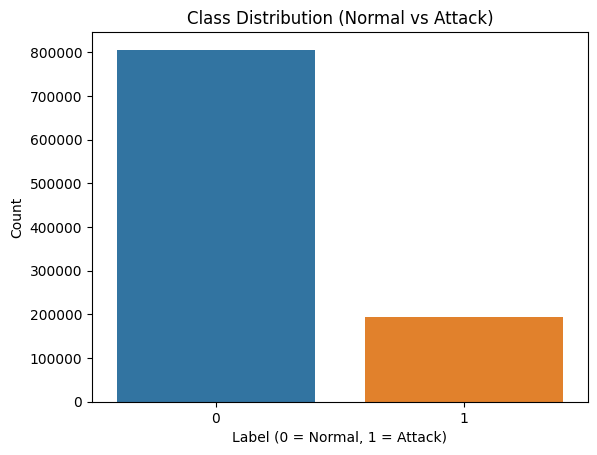

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


label_counts = df_disk['label'].value_counts(normalize=True)
print("Class distribution (proportion):\n", label_counts)


sns.countplot(data=df_disk, x='label')
plt.title('Class Distribution (Normal vs Attack)')
plt.xlabel('Label (0 = Normal, 1 = Attack)')
plt.ylabel('Count')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


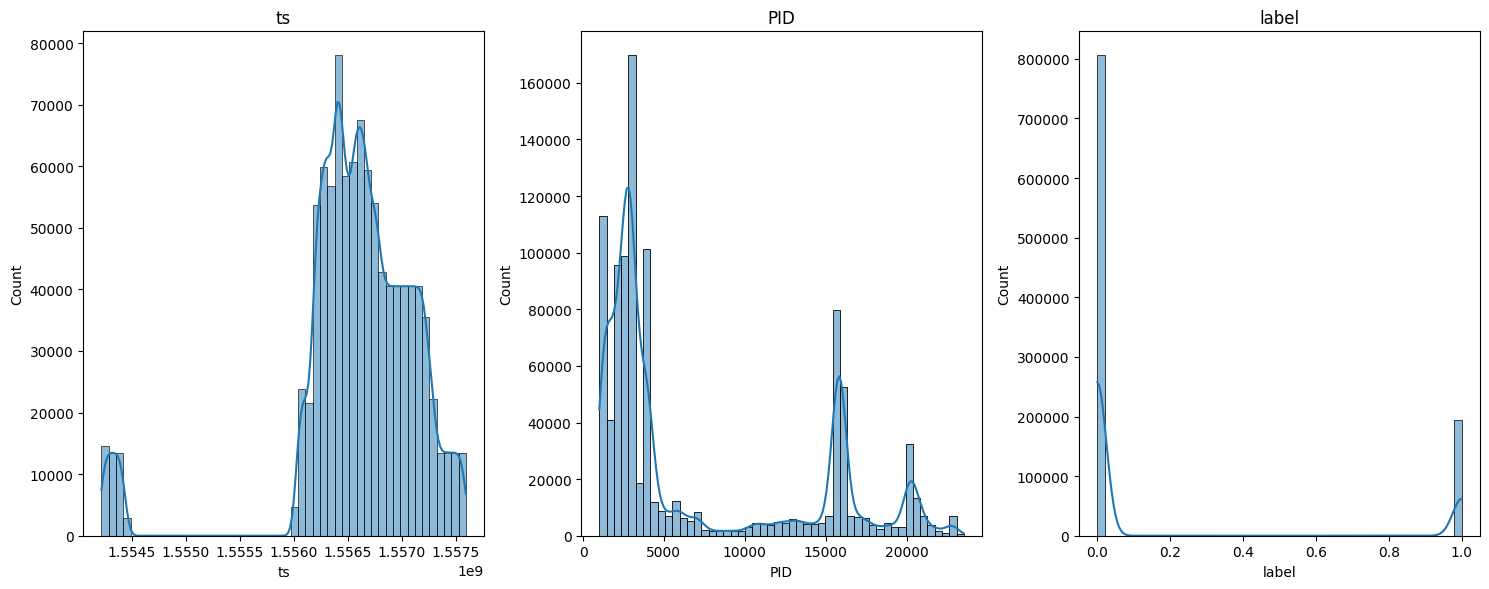

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numeric columns
numeric_cols = df_disk.select_dtypes(include=['int64', 'float64']).columns

# Plot distributions
plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.histplot(df_disk[col], bins=50, kde=True)
    plt.title(col)
    plt.tight_layout()


In [24]:
# Select object-type columns
object_cols = df_disk.select_dtypes(include='object').columns

# Explore each object column
for col in object_cols:
    print(f"\n--- {col} ---")
    print(f"Unique values: {df_disk[col].nunique()}")
    print(f"Top 5 most frequent values:\n{df_disk[col].value_counts().head()}")
    print(f"\nSample of 5 least frequent values:\n{df_disk[col].value_counts().tail()}")
    print(f"\nTop value proportion: {df_disk[col].value_counts(normalize=True).iloc[0]:.4f}")



--- RDDSK ---
Unique values: 878
Top 5 most frequent values:
RDDSK
0.0    867409
0       72779
0K      56688
4.0       370
4K        155
Name: count, dtype: int64

Sample of 5 least frequent values:
RDDSK
336K      1
4480K     1
4496K     1
5272K     1
2508.0    1
Name: count, dtype: int64

Top value proportion: 0.8674

--- WRDSK ---
Unique values: 1098
Top 5 most frequent values:
WRDSK
0     645647
0     125998
4      85368
0K     45617
8      25067
Name: count, dtype: int64

Sample of 5 least frequent values:
WRDSK
2784       1
3404       1
3780       1
3652       1
20804.0    1
Name: count, dtype: int64

Top value proportion: 0.6456

--- WCANCL ---
Unique values: 80
Top 5 most frequent values:
WCANCL
0      863530
0      129800
4        5261
4        1205
8.0        37
Name: count, dtype: int64

Sample of 5 least frequent values:
WCANCL
7068    1
3772    1
2.5     1
6940    1
2472    1
Name: count, dtype: int64

Top value proportion: 0.8635

--- DSK ---
Unique values: 291
Top 5 mos

In [27]:
import pandas as pd
import numpy as np

# 1. Drop PID and type
df_disk = df_disk.drop(columns=['PID', 'type'])

# 2. Timestamp engineering
df_disk['ts'] = pd.to_datetime(df_disk['ts'], unit='s')
df_disk['hour']       = df_disk['ts'].dt.hour
df_disk['day_of_week']= df_disk['ts'].dt.dayofweek
df_disk['is_weekend'] = df_disk['day_of_week'].isin([5, 6]).astype(int)
df_disk = df_disk.drop(columns=['ts'])

# 3. Clean numeric-like object columns
def clean_disk_col(s):
    def parse(x):
        x = str(x).strip()
        if x.endswith('K'):
            return float(x[:-1]) * 1024
        if x.endswith('%'):
            return float(x[:-1]) / 100
        try:
            return float(x)
        except:
            return np.nan
    return s.map(parse)

for col in ['RDDSK', 'WRDSK', 'WCANCL', 'DSK']:
    df_disk[col] = clean_disk_col(df_disk[col])

# Drop rows with any NaNs in those columns



KeyError: 'ts'

In [28]:
df_disk.dropna(subset=['RDDSK', 'WRDSK', 'WCANCL', 'DSK'], inplace=True)

# 4. Target-encode CMD
# (Assuming df_disk has 'label' column)
global_mean = df_disk['label'].mean()
agg = df_disk.groupby('CMD')['label'].agg(['mean','count'])
k = 10
smooth = (agg['count'] * agg['mean'] + k * global_mean) / (agg['count'] + k)
df_disk['CMD_encoded'] = df_disk['CMD'].map(smooth).fillna(global_mean)
df_disk.drop(columns=['CMD'], inplace=True)

# 5. Final check
print(df_disk.dtypes)
print(df_disk.isna().sum())
print(df_disk.head())

RDDSK          float64
WRDSK          float64
WCANCL         float64
DSK            float64
label            int64
hour             int32
day_of_week      int32
is_weekend       int64
CMD_encoded    float64
dtype: object
RDDSK          0
WRDSK          0
WCANCL         0
DSK            0
label          0
hour           0
day_of_week    0
is_weekend     0
CMD_encoded    0
dtype: int64
     RDDSK    WRDSK   WCANCL   DSK  label  hour  day_of_week  is_weekend  \
0    148.2  37340.0  12328.0  0.22      0    15            1           0   
1  32824.0    688.0      4.0  0.04      0    15            1           0   
2  23468.0   7416.0   6152.0  0.04      0    15            1           0   
3   3612.0  14320.0      0.0  0.02      0    15            1           0   
4   5184.0  11152.0      0.0  0.02      0    15            1           0   

   CMD_encoded  
0     0.347353  
1     0.106065  
2     0.244935  
3     0.120736  
4     0.305964  


In [29]:
# ========================================
# 1. Imports
# ========================================
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import joblib

# ========================================
# 2. Feature/Target Split
# ========================================
X = df_disk.drop(columns=["label"])
y = df_disk["label"]

# ========================================
# 3. Train/Validation Split
# ========================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Important because of imbalance
)

# ========================================
# 4. Handle Imbalance
# ========================================
# Calculate scale_pos_weight for XGBoost/LightGBM
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# ========================================
# 5. Model Definitions
# (only high-performance models)
# ========================================
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

lgbm_model = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

catboost_model = CatBoostClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=0
)

models = {
    "XGBoost": xgb_model,
    "LightGBM": lgbm_model,
    "CatBoost": catboost_model
}


Calculated scale_pos_weight: 4.18


In [30]:
from sklearn.metrics import classification_report, roc_auc_score
import time

# List of models to evaluate
models = {
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1),
    "CatBoost": CatBoostClassifier(scale_pos_weight=scale_pos_weight, random_state=42, verbose=0)
}

# Evaluation loop
for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1]
    
    print(classification_report(y_val, preds, digits=4))
    roc_auc = roc_auc_score(y_val, probs)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {classification_report(y_val, preds, output_dict=True)['1']['f1-score']:.4f}")
    print(f"Training + Evaluation Time: {time.time() - start_time:.2f} seconds")



=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9861    0.7966    0.8813    161024
           1     0.5288    0.9532    0.6802     38554

    accuracy                         0.8269    199578
   macro avg     0.7575    0.8749    0.7808    199578
weighted avg     0.8978    0.8269    0.8425    199578

ROC-AUC Score: 0.9371
F1 Score: 0.6802
Training + Evaluation Time: 4.31 seconds

=== LightGBM ===
[LightGBM] [Info] Number of positive: 154216, number of negative: 644092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 798308, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193179 -> initscore=-1.429487
[LightGBM] [Info] Start training from score -1.429487

In [31]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5]
}

# Initialize the model
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    cv=3,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_

print("\nBest Parameters:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  28.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  28.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1.5, subsample=1.0; total time=  28.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  23.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  23.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=  38.2s
[CV] END colsampl

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [32]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import time

start_time = time.time()

# Predict
y_pred = best_xgb.predict(X_val)
y_proba = best_xgb.predict_proba(X_val)[:, 1]

# Metrics
print("=== Tuned XGBoost Evaluation ===")
print(classification_report(y_val, y_pred, digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_proba):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")
print(f"Evaluation Time: {time.time() - start_time:.2f} seconds")


=== Tuned XGBoost Evaluation ===
              precision    recall  f1-score   support

           0     0.9850    0.8047    0.8858    161024
           1     0.5378    0.9490    0.6865     38554

    accuracy                         0.8326    199578
   macro avg     0.7614    0.8769    0.7862    199578
weighted avg     0.8987    0.8326    0.8473    199578

ROC-AUC Score: 0.9387
F1 Score: 0.6865
Evaluation Time: 2.81 seconds


In [33]:
import joblib

# Save tuned XGBoost model
joblib.dump(best_xgb, 'xgboost_disk_model.pkl')

print("Model saved successfully as 'xgboost_disk_model.pkl'")


Model saved successfully as 'xgboost_disk_model.pkl'
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=  38.0s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1.5, subsample=1.0; total time=  28.8s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=  48.8s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=  38.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=  30.0s
[CV] END c

In [21]:
import pandas as pd

# Paths to your first three CSVs (adjust if needed)
csv_files = [
    "/kaggle/input/networkdatasets/Network_dataset_1.csv",
]

# Load and concatenate
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    print(f"Loaded {file} with shape: {df.shape}")
    dfs.append(df)

# Combine them
df_network = pd.concat(dfs, ignore_index=True)

# Show basic info
print("\n=== Combined Dataset Info ===")
print(f"Shape: {df_network.shape}")
print("\nColumns and Types:\n", df_network.dtypes)
print("\nMissing Values:\n", df_network.isnull().sum())
print("\nFirst 5 Rows:\n", df_network.head())

# Check if there is a timestamp field
possible_time_columns = [col for col in df_network.columns if 'time' in col.lower()]
print("\nPossible Time-related Columns:", possible_time_columns)

# Check class balance if label exists
if 'label' in df_network.columns:
    print("\nLabel Distribution:\n", df_network['label'].value_counts(normalize=True))


/tmp/ipykernel_31/564383941.py:11: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded /kaggle/input/networkdatasets/Network_dataset_1.csv with shape: (1000000, 46)

=== Combined Dataset Info ===
Shape: (1000000, 46)

Columns and Types:
 ts                          int64
src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                  object
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version               

In [32]:
import pandas as pd
import numpy as np
import ipaddress

# --- Work on a copy ---
df_network_clean = df_network.copy()

# --- 1. Create 'is_src_internal' and 'is_dst_internal' ---

def is_private_ip(ip):
    try:
        return int(ipaddress.ip_address(ip).is_private)
    except ValueError:
        # In case of invalid IP address formats
        return np.nan

df_network_clean['is_src_internal'] = df_network_clean['src_ip'].apply(is_private_ip)
df_network_clean['is_dst_internal'] = df_network_clean['dst_ip'].apply(is_private_ip)

# --- 2. Drop irrelevant or redundant columns ---

columns_to_drop = [
    'src_ip',           # Dropping raw IPs
    'dst_ip',
    'dns_query',        # Very sparse + specific, unnecessary at this stage
    'ssl_subject',      # SSL fields - too detailed, sparse
    'ssl_issuer',
    'http_uri',         # High cardinality, privacy issue, can't generalize
    'http_referrer',
    'http_user_agent',  # Can be useful, but too sparse + high cardinality
    'http_orig_mime_types',
    'http_resp_mime_types',
    'weird_addl',       # Very sparse
]

df_network_clean.drop(columns=columns_to_drop, axis=1, inplace=True)

# --- 3. Basic Fixes ---

# 'src_bytes' sometimes looks like object; ensure numeric
df_network_clean['src_bytes'] = pd.to_numeric(df_network_clean['src_bytes'], errors='coerce')
# 'http_trans_depth' looks like object too
df_network_clean['http_trans_depth'] = pd.to_numeric(df_network_clean['http_trans_depth'], errors='coerce')

# --- 4. Confirm ---
print(f"New shape after cleaning: {df_network_clean.shape}")
print(f"Remaining columns:\n{df_network_clean.columns.tolist()}")


New shape after cleaning: (1000000, 37)
Remaining columns:
['ts', 'src_port', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'http_trans_depth', 'http_method', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'weird_name', 'weird_notice', 'label', 'type', 'is_src_internal', 'is_dst_internal']


In [33]:
columns_to_drop = [
    'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected',
    'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established',
    'http_trans_depth', 'http_method', 'http_version', 'http_request_body_len', 
    'http_response_body_len', 'http_status_code',
    'weird_name', 'weird_notice',
    'type'
]

df_network_clean.drop(columns=columns_to_drop, inplace=True)


In [34]:
# Fix src_bytes (convert to numeric)
df_network_clean['src_bytes'] = pd.to_numeric(df_network_clean['src_bytes'], errors='coerce')

# Numerical columns
numerical_cols = [
    'src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 
    'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes'
]

# Categorical columns
categorical_cols = ['proto', 'service', 'conn_state']

# Describe numerical columns
print("=== Numerical Features Summary ===")
print(df_network_clean[numerical_cols].describe())

# Value counts for categorical columns
print("\n=== Categorical Features Distribution ===")
for col in categorical_cols:
    print(f"\n{col} distribution:")
    print(df_network_clean[col].value_counts(normalize=True) * 100)


=== Numerical Features Summary ===
             src_port        dst_port        duration     src_bytes  \
count  1000000.000000  1000000.000000  1000000.000000  9.998250e+05   
mean     35757.766235    23149.785514        2.615656  1.289378e+03   
std      18764.660143    20428.939014      184.221765  2.701452e+05   
min          0.000000        0.000000        0.000000  0.000000e+00   
25%      20426.000000     5101.000000        0.000000  0.000000e+00   
50%      39339.000000    15856.500000        0.000000  0.000000e+00   
75%      51502.000000    40688.000000        0.000000  0.000000e+00   
max      65535.000000    65535.000000    85274.354600  1.337509e+08   

          dst_bytes  missed_bytes        src_pkts  src_ip_bytes  \
count  1.000000e+06  1.000000e+06  1000000.000000  1.000000e+06   
mean   1.953731e+03  5.709888e+02        2.909724  5.254827e+02   
std    3.229004e+05  1.228081e+05      338.259878  8.849577e+04   
min    0.000000e+00  0.000000e+00        0.000000  0.0000

In [35]:
# List of numerical columns to log-transform
log_transform_cols = [
    'duration', 'src_bytes', 'dst_bytes',
    'missed_bytes', 'src_ip_bytes', 'dst_ip_bytes'
]

# Apply log1p (log(1+x)) transformation safely
for col in log_transform_cols:
    df_network_clean[col] = np.log1p(df_network_clean[col])

# Cap extremely large packet counts to avoid outlier impact in live environment
df_network_clean['src_pkts'] = np.clip(df_network_clean['src_pkts'], 0, 1e4)
df_network_clean['dst_pkts'] = np.clip(df_network_clean['dst_pkts'], 0, 1e4)

# Create 'missed_bytes_flag' based on missed_bytes before dropping it
df_network_clean['missed_bytes_flag'] = (df_network_clean['missed_bytes'] > 0).astype(int)

# Drop 'missed_bytes' (after creating flag)
df_network_clean.drop(columns=['missed_bytes'], inplace=True)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
from sklearn.preprocessing import LabelEncoder

# Columns to treat
categorical_cols = ['proto', 'service', 'conn_state', 'is_src_internal', 'is_dst_internal']

# 1. Fix 'is_src_internal' first (was wrongly object type)
df_network_clean['is_src_internal'] = pd.to_numeric(df_network_clean['is_src_internal'], errors='coerce').fillna(0).astype(int)

# 2. Fill missing categorical values (safe, precaution)
df_network_clean[categorical_cols] = df_network_clean[categorical_cols].fillna('-')

# 3. Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_network_clean[col] = le.fit_transform(df_network_clean[col])
    label_encoders[col] = le


In [37]:
print("=== Dataset Overview ===")
print(f"Shape: {df_network_clean.shape}")

print("\n=== Data Types ===")
print(df_network_clean.dtypes)

print("\n=== Missing Values ===")
print(df_network_clean.isnull().sum())

print("\n=== Sample Rows ===")
print(df_network_clean.head())

print("\n=== Basic Statistics ===")
print(df_network_clean.describe())
# Check unique values for all columns (especially categoricals)
print("\n=== Unique Values per Column ===")
for col in df_network_clean.columns:
    print(f"{col}: {df_network_clean[col].nunique()} unique values")


=== Dataset Overview ===
Shape: (1000000, 17)

=== Data Types ===
ts                     int64
src_port               int64
dst_port               int64
proto                  int64
service                int64
duration             float64
src_bytes            float64
dst_bytes            float64
conn_state             int64
src_pkts               int64
src_ip_bytes         float64
dst_pkts               int64
dst_ip_bytes         float64
label                  int64
is_src_internal        int64
is_dst_internal        int64
missed_bytes_flag      int64
dtype: object

=== Missing Values ===
ts                     0
src_port               0
dst_port               0
proto                  0
service                0
duration               0
src_bytes            175
dst_bytes              0
conn_state             0
src_pkts               0
src_ip_bytes           0
dst_pkts               0
dst_ip_bytes           0
label                  0
is_src_internal        0
is_dst_internal        0
mis

In [38]:

median_src_bytes = df_network_clean['src_bytes'].median()
df_network_clean['src_bytes'].fillna(median_src_bytes, inplace=True)


import pandas as pd

df_network_clean['ts'] = pd.to_datetime(df_network_clean['ts'], unit='s')
df_network_clean['hour'] = df_network_clean['ts'].dt.hour
df_network_clean['day_of_week'] = df_network_clean['ts'].dt.dayofweek
df_network_clean['is_weekend'] = df_network_clean['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


df_network_clean.drop(columns=['ts'], inplace=True)


/tmp/ipykernel_31/3621716097.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_network_clean['src_bytes'].fillna(median_src_bytes, inplace=True)


In [39]:
df_network_clean.drop(columns=['day_of_week', 'hour', 'is_weekend'], inplace=True)


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb

# 1. Ensure 'label' is not in the features
assert 'label' in df_network_clean.columns, "Label column is missing."
X = df_network_clean.drop(columns=['label'])
y = df_network_clean['label']

# 2. Stratified Train/Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3. Handle Class Imbalance
normal_count = (y_train == 0).sum()
anomaly_count = (y_train == 1).sum()
scale_pos_weight = normal_count / anomaly_count

print(f"Normal samples: {normal_count}, Anomaly samples: {anomaly_count}")
print(f"Scale_pos_weight set to: {scale_pos_weight:.4f}")

# 4. Initialize and Train XGBoost Model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

model.fit(X_train, y_train)

# 5. Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Normal samples: 166943, Anomaly samples: 633057
Scale_pos_weight set to: 0.2637

ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0     0.9973    0.9998    0.9986     41736
           1     0.9999    0.9993    0.9996    158264

    accuracy                         0.9994    200000
   macro avg     0.9986    0.9995    0.9991    200000
weighted avg     0.9994    0.9994    0.9994    200000


Confusion Matrix:
[[ 41728      8]
 [   113 158151]]


label                1.000000
src_ip_bytes         0.610196
is_dst_internal      0.399695
dst_port             0.289956
conn_state           0.230286
is_src_internal      0.120317
src_port             0.007675
src_pkts            -0.018616
dst_pkts            -0.024110
dst_ip_bytes        -0.051508
missed_bytes_flag   -0.055740
duration            -0.145943
dst_bytes           -0.319954
src_bytes           -0.368649
service             -0.395412
proto               -0.505863
Name: label, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


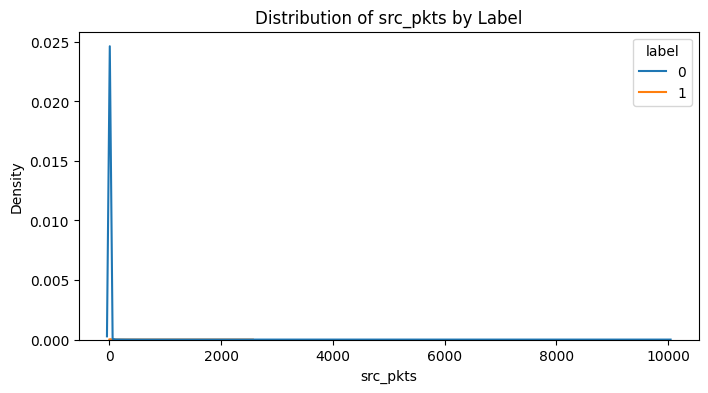

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


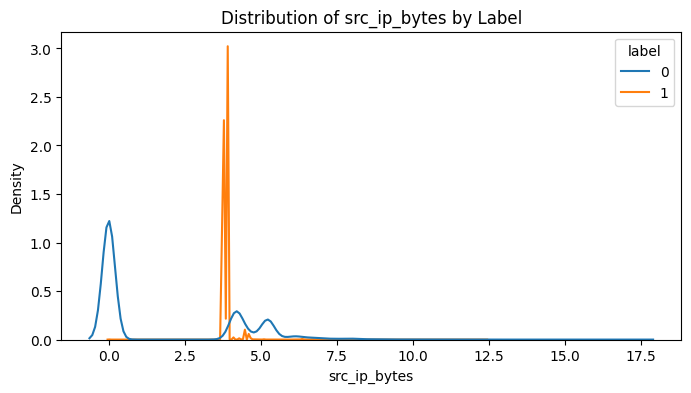

In [31]:
import numpy as np

correlations = df_network_clean.corr()['label'].sort_values(ascending=False)
print(correlations)
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['src_pkts', 'src_ip_bytes']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df_network_clean, x=feature, hue='label', common_norm=False)
    plt.title(f'Distribution of {feature} by Label')
    plt.show()
